In [1]:
from prettytable import PrettyTable
from collections import namedtuple

In [2]:
class Token(object):
    EOS = 0
    ANY = 1
    AT_BOL = 2
    AT_EOL = 3
    CCL_END = 4
    CCL_START = 5
    CLOSE_CURLY = 6
    CLOSE_PAREN = 7
    CLOSURE = 8
    DASH = 9
    END_OF_INPUT = 10
    L = 11 # match a single character
    OPEN_CURLY = 12
    OPEN_PAREN = 13
    OPTIONAL = 14
    OR = 15
    PLUS_CLOSURE = 16


Tokens = {
    '.': Token.ANY,
    '^': Token.AT_BOL,
    '$': Token.AT_EOL,
    ']': Token.CCL_END,
    '[': Token.CCL_START,
    '}': Token.CLOSE_CURLY,
    ')': Token.CLOSE_PAREN,
    '*': Token.CLOSURE,
    '-': Token.DASH,
    '{': Token.OPEN_CURLY,
    '(': Token.OPEN_PAREN,
    '?': Token.OPTIONAL,
    '|': Token.OR,
    '+': Token.PLUS_CLOSURE,
}

token2str = {
    Token.ANY: "Token.ANY",
    Token.AT_BOL: "Token.AT_BOL",
    Token.CCL_END: "Token.CCL_END",
    Token.CCL_START: "Token.CCL_START",
    Token.CLOSE_CURLY: "Token.CLOSE_CURLY",
    Token.CLOSE_PAREN: "Token.CLOSE_PAREN",
    Token.CLOSURE: "Token.CLOSURE",
    Token.DASH: "Token.DASH",
    Token.OPEN_CURLY: "Token.OPEN_CURLY",
    Token.OPEN_PAREN: "Token.OPEN_PAREN",
    Token.OPTIONAL: "Token.OPTIONAL",
    Token.OR: "Token.OR",
    Token.PLUS_CLOSURE: "Token.PLUS_CLOSURE",
    Token.L: "Token.L",
    Token.EOS: "Token.EOS"
}

In [3]:
token2symbol = {}
for (key, val) in Tokens.items():
    token2symbol[val] = key

In [4]:
class Lexer(object):
    
    def __init__(self, pattern):
        self.pattern  = pattern
        self.curPos   = 0
        self.curToken = None
        self.curChar  = ''
        
    def forward(self):
        pos     = self.curPos
        pattern = self.pattern
        if pos >= len(self.pattern):
            self.curToken = Token.EOS
            return Token.EOS
        text = self.curChar = pattern[pos]
        self.curPos += 1
        self.curToken = Tokens.get(text, Token.L)
        return self.curToken
    

In [5]:
lexer = Lexer("([a-z]+|[A-Z]*)")
x = PrettyTable()
x.field_names = ["Token Number", "Token Name", "Symbol", "Lexer Position", "Character"]

In [6]:
for i in range(30):
    token = lexer.forward()
    x.add_row([token, token2str[token], token2symbol.get(token, lexer.curChar), lexer.curPos, lexer.curChar])
    if lexer.curToken == Token.EOS:
        break

In [7]:
print(x)

+--------------+--------------------+--------+----------------+-----------+
| Token Number |     Token Name     | Symbol | Lexer Position | Character |
+--------------+--------------------+--------+----------------+-----------+
|      13      |  Token.OPEN_PAREN  |   (    |       1        |     (     |
|      5       |  Token.CCL_START   |   [    |       2        |     [     |
|      11      |      Token.L       |   a    |       3        |     a     |
|      9       |     Token.DASH     |   -    |       4        |     -     |
|      11      |      Token.L       |   z    |       5        |     z     |
|      4       |   Token.CCL_END    |   ]    |       6        |     ]     |
|      16      | Token.PLUS_CLOSURE |   +    |       7        |     +     |
|      15      |      Token.OR      |   |    |       8        |     |     |
|      5       |  Token.CCL_START   |   [    |       9        |     [     |
|      11      |      Token.L       |   A    |       10       |     A     |
|      9    

In [8]:
class Edge:
    # ε edge
    EPSILON = -1
    # characters
    CCL = -2
    
    def __init__(self):
        self.nextNode = None
        self.status   = Edge.EPSILON
        self.symbols  = ""
        self.charSet = set()

In [9]:


class NFANode(object):
    
    STATUS_NUM = 1
    
    def __init__(self):
        self.visited = False
        self.e1      = None
        self.e2      = None
        self.set_status_num()
        self.fnode   = False
        self.snode   = False
        
        
    def set_status_num(self):
        self.status_num = NFANode.STATUS_NUM
        NFANode.STATUS_NUM    += 1
        

class NFAPair(object):
    
    def __init__(self):
        self.startNode = None
        self.endNode   = None
        

In [10]:

"""
expression = factor expressionPrime
expressionPrime = NULL | factor expressionPrime
factor = term fatcotrPrime
fatcotrPrime = NULL | */?/+ factorPrime | term fatcotrPrime 
term = char | [ char - char ] | . | (expression)
"""

class NFAMachine(object):
    CONSTANT_STATUS = [Token.OPEN_PAREN, Token.ANY, Token.CCL_START, Token.L]

    def __init__(self, pattern):
        self.pattern = pattern
        self.lexer = Lexer(pattern)

    def start_construct(self):
        self.lexer.forward()
        pair = NFAPair()
        self.startPair = pair
        self.expr(pair)
        pair.endNode.fnode = True
        pair.startNode.snode = True

    def expr(self, pair):
        self.factor(pair)
        lexer = self.lexer
        while lexer.curToken != Token.EOS:
            if lexer.curToken != Token.OR:
                raise RuntimeError("current token should be Token.OR")
            lexer.forward()
            tmp = NFAPair()
            self.factor(tmp)
            start = NFANode()
            end = NFANode()
            start.e1 = Edge()
            start.e2 = Edge()

            self.link(start.e1, pair.startNode, Edge.EPSILON, " ε")
            self.link(start.e2, tmp.startNode, Edge.EPSILON, " ε")

            pair.endNode.e1 = Edge()
            self.link(pair.endNode.e1, end, Edge.EPSILON, " ε")

            tmp.endNode.e1 = Edge()
            self.link(tmp.endNode.e1, end, Edge.EPSILON, " ε")

            pair.startNode = start
            pair.endNode = end

    def link(self, edge, end, status, symbol):
        edge.nextNode = end
        edge.status = status
        edge.symbols = symbol

    def factor(self, pair):
        self.term(pair)
        lexer = self.lexer
        if lexer.curToken == Token.OPTIONAL:
            self.handle_optional_closure(pair)
        elif lexer.curToken == Token.PLUS_CLOSURE:
            self.handle_plus_closure(pair)
        elif lexer.curToken == Token.CLOSURE:
            self.handle_star_closure(pair)

        # below is for factor prime
        while lexer.curToken in NFAMachine.CONSTANT_STATUS:
            tmp = NFAPair()
            self.term(tmp)
            if lexer.curToken == Token.OPTIONAL:
                self.handle_optional_closure(tmp)
            elif lexer.curToken == Token.PLUS_CLOSURE:
                self.handle_plus_closure(tmp)
            elif lexer.curToken == Token.CLOSURE:
                self.handle_star_closure(tmp)
            pair.endNode.e1 = tmp.startNode.e1
            pair.endNode.e2 = tmp.startNode.e2
            pair.endNode = tmp.endNode

    def handle_optional_closure(self, pair):
        start = NFANode()
        end = NFANode()

        start.e1 = Edge()
        start.e1.nextNode = pair.startNode
        start.e1.status = Edge.EPSILON
        start.e1.symbols = " ε"

        start.e2 = Edge()
        start.e2.nextNode = end
        start.e2.status = Edge.EPSILON
        start.e2.symbols = " ε"

        pair.endNode.e1 = Edge()
        pair.endNode.e1.nextNode = end
        pair.endNode.e1.status = Edge.EPSILON
        pair.endNode.e1.symbols = " ε"

        pair.startNode = start
        pair.endNode = end

        self.lexer.forward()
        return True

    def handle_plus_closure(self, pair):
        start = NFANode()
        end = NFANode()

        start.e1 = Edge()
        start.e1.nextNode = pair.startNode
        start.e1.status = Edge.EPSILON
        start.e1.symbols = " ε"

        pair.endNode.e1 = Edge()
        pair.endNode.e1.nextNode = end
        pair.endNode.e1.status = Edge.EPSILON
        pair.endNode.e1.symbols = " ε"

        pair.endNode.e2 = Edge()
        pair.endNode.e2.nextNode = pair.startNode
        pair.endNode.e2.status = Edge.EPSILON
        pair.endNode.e2.symbols = " ε"

        pair.startNode = start
        pair.endNode = end

        self.lexer.forward()
        return True

    def handle_star_closure(self, pair):
        start = NFANode()
        end = NFANode()

        start.e1 = Edge()
        start.e1.nextNode = pair.startNode
        start.e1.status = Edge.EPSILON
        start.e1.symbols = " ε"

        start.e2 = Edge()
        start.e2.nextNode = end
        start.e2.status = Edge.EPSILON
        start.e2.symbols = " ε"

        pair.endNode.e1 = Edge()
        pair.endNode.e1.nextNode = end
        pair.endNode.e1.status = Edge.EPSILON
        pair.endNode.e1.symbols = " ε"

        pair.endNode.e2 = Edge()
        pair.endNode.e2.nextNode = pair.startNode
        pair.endNode.e2.status = Edge.EPSILON
        pair.endNode.e2.symbols = " ε"

        pair.startNode = start
        pair.endNode = end

        self.lexer.forward()
        return True

    def term(self, pair):
        if self.lexer.curToken == Token.L:
            self.match_single_char(pair)
        elif self.lexer.curToken == Token.CCL_START:
            self.match_ccl_start(pair)
        elif self.lexer.curToken == Token.ANY:
            self.match_any(pair)
        elif self.lexer.curToken == Token.OPEN_PAREN:
            pair.startNode = NFANode()
            pair.endNode = NFANode()
            tmp = NFAPair()
            self.lexer.forward()
            self.sub_expr(tmp)
            edge = Edge()
            pair.startNode.e1 = edge
            edge.nextNode = tmp.startNode
            edge.status = Edge.EPSILON
            edge.symbols = " ε"

            tmp.endNode.e1 = Edge()
            tmp.endNode.e1.nextNode = pair.endNode
            tmp.endNode.e1.status = Edge.EPSILON
            tmp.endNode.e1.symbols = " ε"

            pair.endNode = tmp.endNode

            self.lexer.forward()

    def sub_expr(self, pair):
        self.factor(pair)
        lexer = self.lexer
        while lexer.curToken != Token.CLOSE_PAREN:
            if lexer.curToken != Token.OR:
                raise RuntimeError("current token should be Token.OR")
            lexer.forward()
            tmp = NFAPair()
            self.factor(tmp)
            start = NFANode()
            end = NFANode()
            start.e1 = Edge()
            start.e2 = Edge()

            self.link(start.e1, pair.startNode, Edge.EPSILON, " ε")
            self.link(start.e2, tmp.startNode, Edge.EPSILON, " ε")

            pair.endNode.e1 = Edge()
            self.link(pair.endNode.e1, end, Edge.EPSILON, " ε")

            tmp.endNode.e1 = Edge()
            self.link(tmp.endNode.e1, end, Edge.EPSILON, " ε")

            pair.startNode = start
            pair.endNode = end

    def match_single_char(self, pair):
        if self.lexer.curToken != Token.L:
            return False
        pair.startNode = NFANode()
        edge = Edge()
        pair.startNode.e1 = edge
        edge.nextNode = NFANode()
        edge.status = Edge.CCL
        edge.symbols = self.pattern[self.lexer.curPos - 1]
        edge.charSet.add(edge.symbols)
        pair.endNode = edge.nextNode
        self.lexer.forward()
        return True

    def match_ccl_start(self, pair):
        if self.lexer.curToken != Token.CCL_START:
            return
        self.lexer.forward()
        pair.startNode = NFANode()
        edge = Edge()
        pair.startNode.e1 = edge
        edge.nextNode = NFANode()
        edge.status = Edge.CCL
        pair.endNode = edge.nextNode

        sp = self.lexer.curPos - 2
        while self.lexer.curToken != Token.CCL_END:
            if self.lexer.curChar == '-':
                for i in range(ord(self.pattern[self.lexer.curPos - 2]) + 1,
                               ord(self.pattern[self.lexer.curPos]) + 1):
                    edge.charSet.add(chr(i))
            else:
                edge.charSet.add(self.lexer.curChar)
            self.lexer.forward()
        pair.startNode.e1.symbols = " " + self.pattern[sp:self.lexer.curPos]
        self.lexer.forward()
        return True

    def match_any(self, pair):
        if self.lexer.curToken != Token.ANY:
            return False
        pair.startNode = NFANode()
        pair.startNode.e1 = Edge()
        pair.startNode.e1.nextNode = NFANode()
        pair.startNode.e1.status = Edge.CCL
        pair.startNode.e1.symbols = '.'
        for i in range(127):
            pair.startNode.e1.charSet.add(chr(i))
        pair.endNode = pair.startNode.e1.nextNode
        self.lexer.forward()
        return True

    def fetch_start_node(self):
        return self.startPair.startNode

    def match(self, s):
        """
        back tracing algorithm
        """
        node = self.fetch_start_node()
        return self.depth_first_search(node, s, 0)

    def depth_first_search(self, node: NFANode, s, curPos):

        if node.fnode and curPos == len(s):
            return True

        if node.e1 is not None:
            if node.e1.status == Edge.EPSILON:
                if self.depth_first_search(node.e1.nextNode, s, curPos):
                    return True
            else:
                if curPos >= len(s):
                    return False
                if s[curPos] in node.e1.charSet:
                    if self.depth_first_search(node.e1.nextNode, s, curPos + 1):
                        return True
        if node.e2 is not None:
            if node.e2.status == Edge.EPSILON:
                if self.depth_first_search(node.e2.nextNode, s, curPos):
                    return True

            else:
                if curPos >= len(s):
                    return False
                if s[curPos] in node.e2.charSet:
                    if self.depth_first_search(node.e2.nextNode, s, curPos + 1):
                        return True
        return False


In [11]:
from graphviz import Graph, Digraph

In [12]:
def dfs(node: NFANode, dot):
    if node.visited:
        return
    node.visited = True
    if node.snode == True:
        dot.node(str(node.status_num), "", fillcolor='#ed6a5e', style='filled')
    elif node.fnode == True:
        dot.node(str(node.status_num), "", fillcolor='#61c554', style='filled')
    else:
        dot.node(str(node.status_num), "")
    if node.e1 != None:
        edge = node.e1
        dot.node(str(node.e1.nextNode.status_num), "")
        dot.edge(str(node.status_num), str(edge.nextNode.status_num), edge.symbols)
        dfs(edge.nextNode, dot)

    if node.e2 != None:
        edge = node.e2
        dot.node(str(edge.nextNode.status_num), "")
        dot.edge(str(node.status_num), str(edge.nextNode.status_num), edge.symbols)
        dfs(edge.nextNode, dot)


In [13]:
m = NFAMachine("a(b|c)*")
m.start_construct()

In [14]:
node = m.startPair.startNode
dot = Digraph(graph_attr={'rankdir': "LR"})
dfs(node, dot)

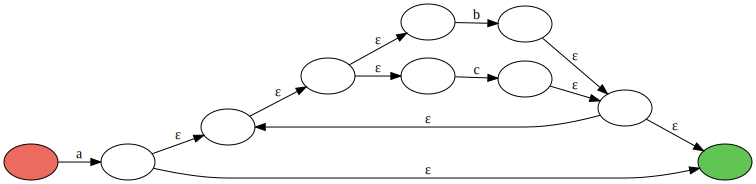

In [15]:
dot

In [16]:
dot.render()

'Digraph.gv.pdf'

In [17]:
!open Digraph.gv.pdf